# Enunciado del Problema



Los datos de la red han sido extraído de la red de usuarios seguidores de cuentas de la salud utilizadas para descargar los datos de la shared-task [SocialDisNER](https://zenodo.org/record/6803567), celebrada en el año 2022. Esencialmente se eligieron un conjunto de 100 cuentas seed, de las que se descargaron sus seguidores y los seguidores de sus seguidores, filtrando algunas de las cuentas para los datos del ejercicio.

Los datos ofrecidos están compuestos por:

- Una lista de nodos en formato *.tsv*, compuestos por una columna que representa la descripción del perfil, una columna de identificación, y una columna llamada *grupo* que representa el tipo de perfil del nodo.

- Una lista de aristas en formato *.tsv*, compuestos por dos columnas que representan el origen y el destino de las uniones entre los nodos.

# Imports

In [ ]:
# Cargamos e instalamos librería que se utilizará
!pip install networkx[default]
!pip install matplotlib==3.1.3
!pip install scipy==1.10.1

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import string
import pandas as pd
import seaborn as sns
import numpy as np

# Descarga y carga de datos

Descargamos los datos y los descomprimimos.

In [ ]:
!wget https://github.com/luisgasco/ntic_master_datos/files/10912179/datos_ejercicio_twitter.zip
!unzip datos_ejercicio_twitter.zip

Cargamos los nodos y las aristas:

In [ ]:
nodos = pd.read_csv("nodos_ejercicio.tsv",sep="\t")
aristas = pd.read_csv("aristas_ejercicio.tsv",sep="\t")

Se eliminan dos nodos de los datos cargados, ya que si no se obtiene un subgrafo dirigido con dos componentes, algo más complejo.

In [ ]:
nodos = nodos[~nodos.Target.isin([187715558, 201414730])].copy()
aristas = aristas[~aristas.Target.isin([187715558, 201414730])].copy()

In [ ]:
display(aristas.shape)
aristas.head()

(10122, 2)

Source              Target
0  2838611488  920282323446312960
1  2838611488           293585906
2  2838611488  841702109431103488
3  2838611488          4923112696
4  2838611488          3261814737

No parecen existir atributos entre las conxiones

In [ ]:
aristas.isnull().sum()

Source    0
Target    0
dtype: int64

Tampoco existen valores faltantes en el data set de los vertices.

In [ ]:
aristas['Source2'] = aristas.Source
aristas = aristas.set_index('Source2')
aristas.head()

Creamos la red, indicando que es una red dirigida:

In [ ]:
G = nx.from_pandas_edgelist(aristas, 'Source', 'Target', create_using=nx.DiGraph())

Dataframe de Nodos

In [ ]:
display(nodos.shape)
nodos.head()

(590, 3)

Target                                        description  \
0  920282323446312960  Perfil oficial de la Asociación Española de La...   
1           293585906  Asociación Síndrome 22q11 que representa a las...   
2  841702109431103488  Twitter oficial de ABADIP Associació Balear Dè...   
3          4923112696                                                NaN   
4          3261814737  Sanofi Genzyme, comprometidos con el descubrim...   

        grupo  
0  asociacion  
1  asociacion  
2  asociacion  
3    no_class  
4    no_class

Este dataframe por su parte si contiene atributos para los nodos, y la descripción es un atributo de cada nodo que nos brinda más información acerca de este.

In [ ]:
nodos.isnull().sum()

Target          0
description    14
grupo           0
dtype: int64

Existen valores nulos sobre los que se tendra que evaluar que hacer.

In [ ]:
nodos.nunique()

Target         590
description    576
grupo            4
dtype: int64

In [ ]:
nodos.grupo.value_counts()

asociacion    332
no_class      206
ong            35
fundacion      17
Name: grupo, dtype: int64

In [ ]:
nodos.loc[nodos.description.isnull(), 'description'] = f'Missing description {nodos.Target}'

Se decide asignarles una cadena de texto para identificarlos como missing e incluir el número de identificación para poder distinguir estos casos cuando toque hacerlo.

In [ ]:
nodos[nodos.grupo =='asociacion']['description']

0                                                          Perfil oficial de la Asociación Española de Laboratorios de Medicamentos Huérfanos y Ultrahuérfanos.
1            Asociación Síndrome 22q11 que representa a las familias y afectados por el Síndrome22q11 (Deleción/duplicación) 22q11.2, síndrome(VCFS), DiGeorge.
2                                                                                         Twitter oficial de ABADIP Associació Balear Dèficits Immunes Primaris
8                                           Asociación de pacientes con mucopolisacaridosis (MPS) que defiende el derecho a tratamiento y mejor calidad de vida
9                                                                         Asociación de familiares y afectados por Lipodistrofia España, Europa y Latinoamérica
                                                                                 ...                                                                           
583           Albi España, es una asocia

In [ ]:
nodos[nodos.grupo =='ong']['description']

5               Somos un grupo sin ánimo de lucro que luchamos por la gente que sufre enfermedades poco frecuentes. Estamos empezando nuestra andadura con mucho ánimo.
22                Entidad sin ánimo de lucro destinada a mejorar la calidad de vida de personas afectadas por una enfermedad rara/crónica y sus familias.\n#EERRGalicia
50       ABEA es una organización sin ánimo de lucro que lucha por los derechos y por una mejor calidad de vida de las personas afectadas por la enfermedad de Andrade.
55                  Entidad sin ánimo de lucro. Trabajamos para mejorar la calidad de vida de personas que conviven con enfermedad neuromuscular.  #RedASEM #Capaces15N
76              Entidad de iniciativa social sin ánimo de lucro con el fin de promover el bienestar y la calidad de vida de las personas con autismo y de sus familias.
80                  Organización no lucrativa comprometida con la calidad de vida y la transparencia en #saludmental.\nNos mueve la construcción de un mundo más

In [ ]:
nodos[nodos.grupo =='fundacion']['description']

23                                             Fundación Ana Carolina Díez Mahou. Ayudando a mejorar la calidad de vida de los niños con enfermedades neuromusculares.
30                FUNDACIÓN SÍNDROME WOLF HIRSCHHORN o 4p- #FSWH #alimentacionswh #cocinasinexclusiones #guíacomedoresescolares #wolfhirschhorn #4pmenos 4pmenos@gmail
47       La Fundación Menudos Corazones ayuda a niñas, niños, adolescentes y jóvenes con problemas de corazón (cardiopatías congénitas o adquiridas) y a sus familias.
65                                       La Fundación Contra la Hipertensión Pulmonar (FCHP) pretende mejorar la calidad de vida de los afectados por esta enfermedad.
155                               Fundación Stop Sanfilippo, dedicada al fomento de la investigación para el Sindrome de Sanfilippo y a la asistencia a los afectados.
173               La Fundación Freno al ICTUS trabaja para reducir el impacto del #ictus en nuestra sociedad. Información + Investigación + Inclusión #FrenoalIctu

In [ ]:
nodos[nodos.grupo =='no_class']['description']

3      Missing description 0       920282323446312960\n1                293585906\n2       841702109431103488\n3               4923112696\n4               3261814737\n              ...         \n585              162145289\n586             2289559543\n587    1348697225862537216\n588             3320636101\n589              144889727\nName: Target, Length: 590, dtype: int64
4                                                                                                                                                                                                                                                      Sanofi Genzyme, comprometidos con el descubrimiento de terapias para pacientes con #EnfermedadesRaras.\nhttps://t.co/68u88xxvFL
6                                                                                                                                                                                                                                                         

In [ ]:
nodos_dict = nodos.set_index('Target').to_dict('index').items()
nodos_dict

In [ ]:
G.add_nodes_from(nodos_dict)

In [ ]:
G.is_directed()

True

In [ ]:
posicion = nx.spring_layout(G)

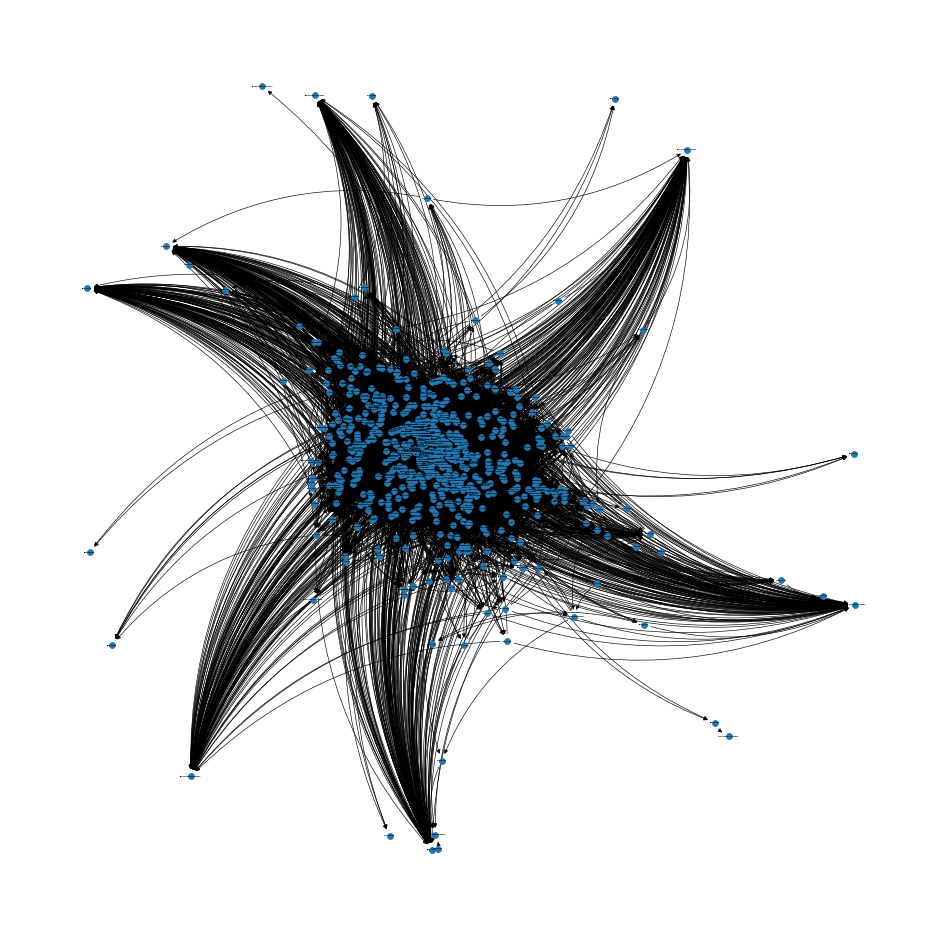

In [ ]:
plt.figure(1, figsize=(20,20), dpi=60)

nx.draw_networkx_nodes(G, posicion, node_size=50)
nx.draw_networkx_labels(G, posicion, font_size=2, font_weight='bold')
nx.draw_networkx_edges(G, posicion, width=0.75, connectionstyle='arc3, rad=0.2')

plt.axis('off')
plt.show()

Del grafico caben destacar los puntos mas alejados del centro, lo que representa aproximadamente entre 20 y 30 cuentas de usuarios con muchos seguidores (mas de la media).

# Análisis topológico

In [ ]:
print(f'Existen {G.number_of_nodes()} usuarios en esta red Dirigida creada.')

Existen 622 usuarios en esta red Dirigida creada.


In [ ]:
print(f'Existen {G.number_of_edges()} relaciones entre usuarios en esta red Dirigida creada.')

Existen 10122 relaciones entre usuarios en esta red Dirigida creada.


In [ ]:
num_seguidores = dict(G.in_degree())
#num_seguidores

In [ ]:
max_seguidores = max(num_seguidores.values())

usuario_maximo = [usuario for usuario in num_seguidores.keys() if num_seguidores[usuario] == max_seguidores][0]

(f'El usuario con mas seguidores es del grupo "{G.nodes[usuario_maximo]["grupo"]}", con {max_seguidores} seguidores y contiene la siguiente descripcion: {G.nodes[usuario_maximo]["description"]}')

'El usuario con mas seguidores es del grupo "asociacion", con 237 seguidores y contiene la siguiente descripcion: Trabajamos por el Derecho Universal a la #Salud. Damos voz y apoyamos la labor de las asociaciones de #pacientes. ¡Unidos somos más! @Isabel_Andrades'

In [ ]:
ordenado_seguidores = sorted(num_seguidores.items(), key=lambda x: x[1], reverse=True)
mas_seguidores = ordenado_seguidores[:10]

descripciones = {}
for i, v in mas_seguidores:
  descripciones[i] = {'id_tweet': i, 'descripcion': G.nodes[i]['description']}

In [ ]:
df_desc = pd.DataFrame.from_dict(descripciones, orient='index')
df_desc

id_tweet  \
256303752                      256303752   
2974326351                    2974326351   
271099251                      271099251   
367210075                      367210075   
1280142038667755520  1280142038667755520   
308131267                      308131267   
847726106937409536    847726106937409536   
198867180                      198867180   
19394390                        19394390   
1327897933036072963  1327897933036072963   

                                                                                                                                                                            descripcion  
256303752                         Trabajamos por el Derecho Universal a la #Salud. Damos voz y apoyamos la labor de las asociaciones de #pacientes. ¡Unidos somos más! @Isabel_Andrades  
2974326351           Agrupamos a 33 organizaciones de #pacientes y 1.450 asociaciones para representar a personas con enfermedades crónicas y/o síntomas cronificados.\n\n#pacientesPOP  
271099251                            Información, formación, servicios y trabajo colaborativo para #asociaciones de #pacientes. Un proyecto participativo, social y sin ánimo de lucro.  
367210075                        Diario online más influyente en el sector sanitario en España. Toda la #ActualidadSanitaria. Porque salud necesitamos todos... https://t.co/N6XiCOAaTL  
1280142038667755520    Somos una Empresa que se dedica a la Virtualización y Digitalización de Congresos, Eventos, Seminarios y Reuniones. Solicita tu demo. \n📬 alan.m@vcongresses.com  
308131267               Espacio digital de noticias: accesibilidad, discapacidad, empleo, políticas sociales, organizaciones... Todo lo que se cuece en la red acerca de la diversidad.  
847726106937409536            El periodismo de las personas. Medio de salud e inclusión social. Medio Oficial del @RPDiscapacidad, @festivalalmagro, @AngelNietoFund y @FrontiersHealth  
198867180                                  La voz del ciudadano en materia de salud.\n\n🗣 #DefensadelPacienteFEP #lavozdelpaciente\n\n💚 #EscaparateDelAsociacionismo\n\n🙌 #EncuentroFEP  
19394390                    Somos la voz de 3 millones de personas con #enfermedadesraras en España. Representamos a 387 asociaciones de pacientes y a 1.313 patologías poco frecuentes  
1327897933036072963        Asociación de #Enfermedades #Raras de #Alcalá de Henares principales #misiones #concienciar #difundir #sensibilizar las  #EnfermedadesRaras e #investigación

In [ ]:
df_mas_seguidores = pd.DataFrame(mas_seguidores, columns=['id_tweet', 'seguidores' ])
df_mas_seguidores

id_tweet  seguidores
0            256303752         237
1           2974326351         211
2            271099251         205
3            367210075         182
4  1280142038667755520         165
5            308131267         161
6   847726106937409536         161
7            198867180         150
8             19394390         148
9  1327897933036072963         139

In [ ]:
df = pd.merge(df_mas_seguidores, df_desc, how='inner')
df

id_tweet  seguidores  \
0            256303752         237   
1           2974326351         211   
2            271099251         205   
3            367210075         182   
4  1280142038667755520         165   
5            308131267         161   
6   847726106937409536         161   
7            198867180         150   
8             19394390         148   
9  1327897933036072963         139   

                                                                                                                                                          descripcion  
0               Trabajamos por el Derecho Universal a la #Salud. Damos voz y apoyamos la labor de las asociaciones de #pacientes. ¡Unidos somos más! @Isabel_Andrades  
1  Agrupamos a 33 organizaciones de #pacientes y 1.450 asociaciones para representar a personas con enfermedades crónicas y/o síntomas cronificados.\n\n#pacientesPOP  
2                  Información, formación, servicios y trabajo colaborativo para #asociaciones de #pacientes. Un proyecto participativo, social y sin ánimo de lucro.  
3              Diario online más influyente en el sector sanitario en España. Toda la #ActualidadSanitaria. Porque salud necesitamos todos... https://t.co/N6XiCOAaTL  
4    Somos una Empresa que se dedica a la Virtualización y Digitalización de Congresos, Eventos, Seminarios y Reuniones. Solicita tu demo. \n📬 alan.m@vcongresses.com  
5     Espacio digital de noticias: accesibilidad, discapacidad, empleo, políticas sociales, organizaciones... Todo lo que se cuece en la red acerca de la diversidad.  
6           El periodismo de las personas. Medio de salud e inclusión social. Medio Oficial del @RPDiscapacidad, @festivalalmagro, @AngelNietoFund y @FrontiersHealth  
7                        La voz del ciudadano en materia de salud.\n\n🗣 #DefensadelPacienteFEP #lavozdelpaciente\n\n💚 #EscaparateDelAsociacionismo\n\n🙌 #EncuentroFEP  
8         Somos la voz de 3 millones de personas con #enfermedadesraras en España. Representamos a 387 asociaciones de pacientes y a 1.313 patologías poco frecuentes  
9        Asociación de #Enfermedades #Raras de #Alcalá de Henares principales #misiones #concienciar #difundir #sensibilizar las  #EnfermedadesRaras e #investigación

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128236 (\N{OPEN MAILBOX WITH RAISED FLAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128483 (\N{SPEAKING HEAD IN SILHOUETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128154 (\N{GREEN HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128588 (\N{PERSON RAISING BOTH HANDS IN CELEBRATION}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


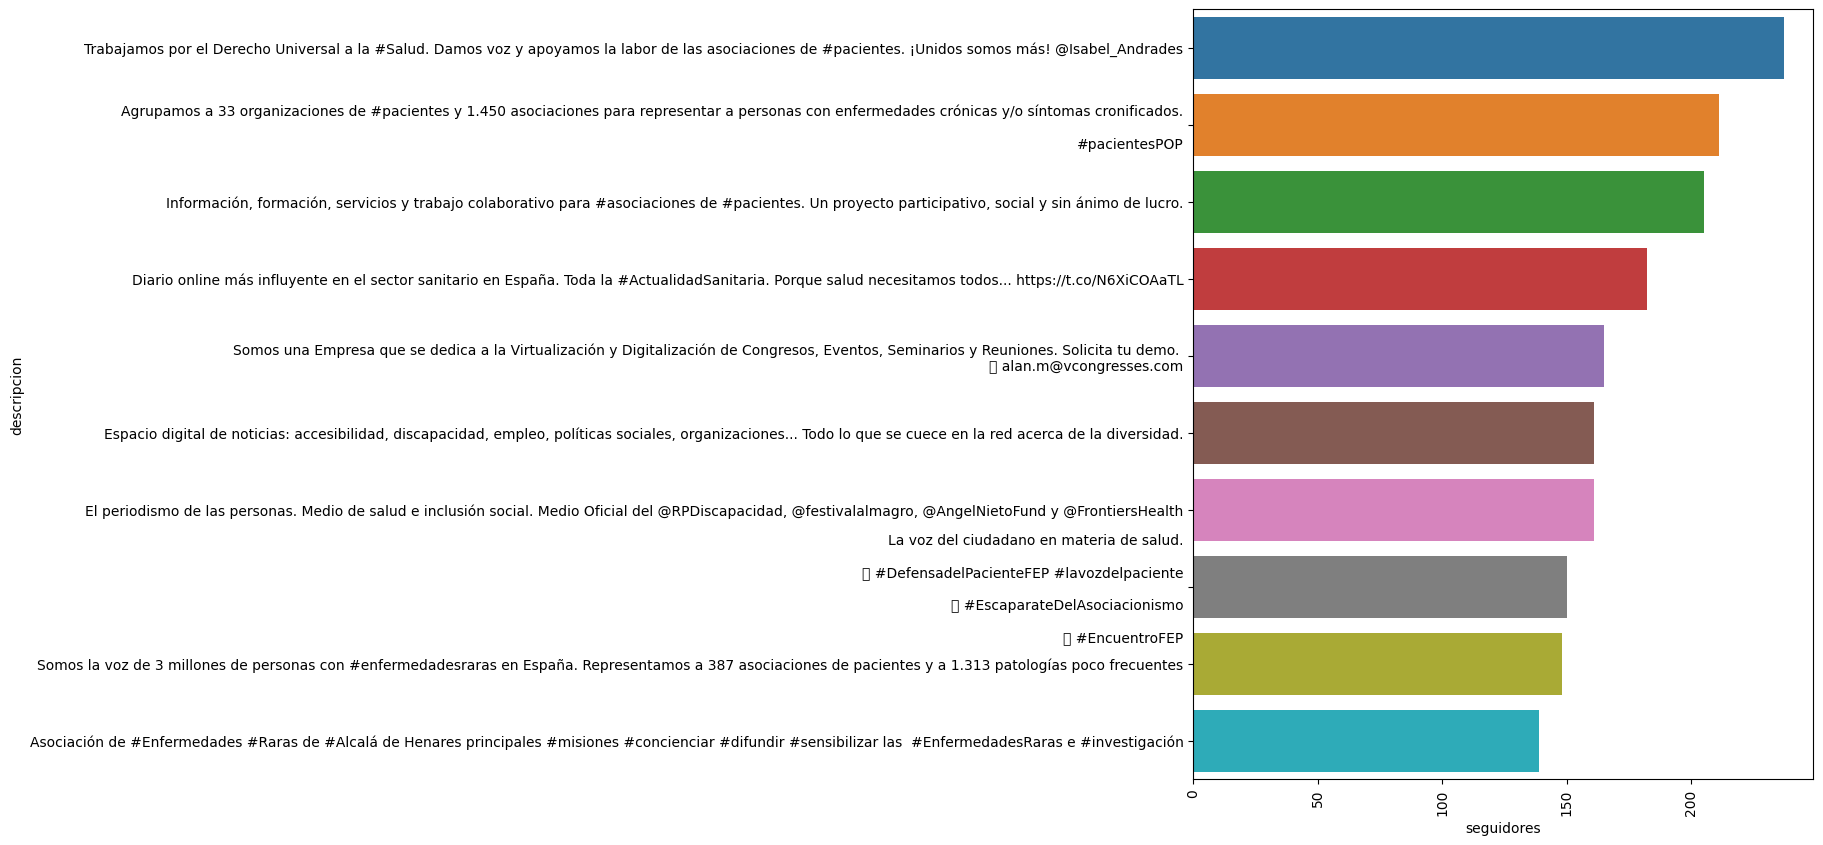

In [ ]:
figure, ax = plt.subplots(figsize=(8, 10))

sns.barplot(y='descripcion', x='seguidores', data=df)
plt.xticks(rotation = 90)
plt.show()

Parece que una asociación cuya administración de la página de twitter es llevada por la usuaria Isabel_Andrades (intuyendo esto porque aparece dicho nombre de usuario en la descripción del perfil), es la que posee más seguidores dentro de este conjunto de datos.

In [ ]:
num_seguidos = dict(G.out_degree())
max_seguidos = max(num_seguidos.values())

seguidos_maximo = [usuario for usuario in num_seguidos.keys() if num_seguidos[usuario] == max_seguidos][0]

(f'El usuario que mas cuentas sigue es del grupo "{G.nodes[seguidos_maximo]["grupo"]}", sigue a {max_seguidos} cuentas y contiene la siguiente descripcion: {G.nodes[seguidos_maximo]["description"]}')

'El usuario que mas cuentas sigue es del grupo "no_class", sigue a 85 cuentas y contiene la siguiente descripcion: Única encuesta en España que evalúa la calidad de la atención sanitaria a los pacientes #crónicos #EsCrónicos2017'

In [ ]:
ordenado_seguidos = sorted(num_seguidos.items(), key=lambda x: x[1], reverse=True)
mas_seguidos = ordenado_seguidos[:10]

descripciones2 = {}
for i, v in mas_seguidos:
  descripciones2[i] = {'id_tweet': i, 'descripcion': G.nodes[i]['description']}

In [ ]:
df_desc2 = pd.DataFrame.from_dict(descripciones2, orient='index')
df_desc2

id_tweet  \
3081297581                    3081297581   
3305988346                    3305988346   
212210916                      212210916   
2385433957                    2385433957   
570631516                      570631516   
1127499633595420672  1127499633595420672   
877527635827593216    877527635827593216   
256303752                      256303752   
2596147543                    2596147543   
402244749                      402244749   

                                                                                                                                                                        descripcion  
3081297581                                                        Única encuesta en España que evalúa la calidad de la atención sanitaria a los pacientes #crónicos #EsCrónicos2017  
3305988346                  Somos un grupo sin ánimo de lucro que luchamos por la gente que sufre enfermedades poco frecuentes. Estamos empezando nuestra andadura con mucho ánimo.  
212210916                             ONG creada en 1996  que representa a las personas con Aniridia y patologías asociadas y sus familiares. Entidad Declarada de Utilidad Pública  
2385433957                                                                                    Asociación de familiares y afectados por Lipodistrofia España, Europa y Latinoamérica  
570631516               Asociación de enfermos de #patologíasmitocondriales. Son enfermedades minoritarias, genéticas,crónicas y degenerativas que no tienen cura en la actualidad.  
1127499633595420672                   Luchamos por una mejora en el ámbito social, sanitario y educativo,   desde febrero de 2019. Conócenos y síguenos!!!\nhttps://t.co/0pzWxgp8KI  
877527635827593216                                      Asociación Aragonesa de Enfermedades Neuromusculares. Entidad declarada de utilidad pública #Tueresloimportante #AsemAragon  
256303752                     Trabajamos por el Derecho Universal a la #Salud. Damos voz y apoyamos la labor de las asociaciones de #pacientes. ¡Unidos somos más! @Isabel_Andrades  
2596147543                  Asociación Española de #SíndromedePoland (hipoplasia unilateral del músculo pectoral mayor) FB: https://t.co/BC0P9aDVVq 𝐁𝐈𝐙𝐔𝐌: 𝟎𝟑𝟕𝟓𝟑\n#enfermedadesrara  
402244749            Asociación de Enfermedades Neuromusculares de Andalucía, sin ánimo de lucro, promocionamos acciones y actividades para mejorar la calidad de vida de afectad@s

In [ ]:
df_mas_seguidos = pd.DataFrame(mas_seguidos, columns=['id_tweet', 'siguiendo' ])
df_mas_seguidos

id_tweet  siguiendo
0           3081297581         85
1           3305988346         84
2            212210916         63
3           2385433957         60
4            570631516         60
5  1127499633595420672         59
6   877527635827593216         58
7            256303752         53
8           2596147543         52
9            402244749         52

In [ ]:
df2 = pd.merge(df_mas_seguidos, df_desc2, how='inner')
df2

id_tweet  siguiendo  \
0           3081297581         85   
1           3305988346         84   
2            212210916         63   
3           2385433957         60   
4            570631516         60   
5  1127499633595420672         59   
6   877527635827593216         58   
7            256303752         53   
8           2596147543         52   
9            402244749         52   

                                                                                                                                                      descripcion  
0                                               Única encuesta en España que evalúa la calidad de la atención sanitaria a los pacientes #crónicos #EsCrónicos2017  
1         Somos un grupo sin ánimo de lucro que luchamos por la gente que sufre enfermedades poco frecuentes. Estamos empezando nuestra andadura con mucho ánimo.  
2                   ONG creada en 1996  que representa a las personas con Aniridia y patologías asociadas y sus familiares. Entidad Declarada de Utilidad Pública  
3                                                                           Asociación de familiares y afectados por Lipodistrofia España, Europa y Latinoamérica  
4     Asociación de enfermos de #patologíasmitocondriales. Son enfermedades minoritarias, genéticas,crónicas y degenerativas que no tienen cura en la actualidad.  
5                   Luchamos por una mejora en el ámbito social, sanitario y educativo,   desde febrero de 2019. Conócenos y síguenos!!!\nhttps://t.co/0pzWxgp8KI  
6                                     Asociación Aragonesa de Enfermedades Neuromusculares. Entidad declarada de utilidad pública #Tueresloimportante #AsemAragon  
7           Trabajamos por el Derecho Universal a la #Salud. Damos voz y apoyamos la labor de las asociaciones de #pacientes. ¡Unidos somos más! @Isabel_Andrades  
8         Asociación Española de #SíndromedePoland (hipoplasia unilateral del músculo pectoral mayor) FB: https://t.co/BC0P9aDVVq 𝐁𝐈𝐙𝐔𝐌: 𝟎𝟑𝟕𝟓𝟑\n#enfermedadesrara  
9  Asociación de Enfermedades Neuromusculares de Andalucía, sin ánimo de lucro, promocionamos acciones y actividades para mejorar la calidad de vida de afectad@s

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119809 (\N{MATHEMATICAL BOLD CAPITAL B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119816 (\N{MATHEMATICAL BOLD CAPITAL I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119833 (\N{MATHEMATICAL BOLD CAPITAL Z}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119828 (\N{MATHEMATICAL BOLD CAPITAL U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119820 (\N{MATHEMATICAL BOLD CAPITAL M}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

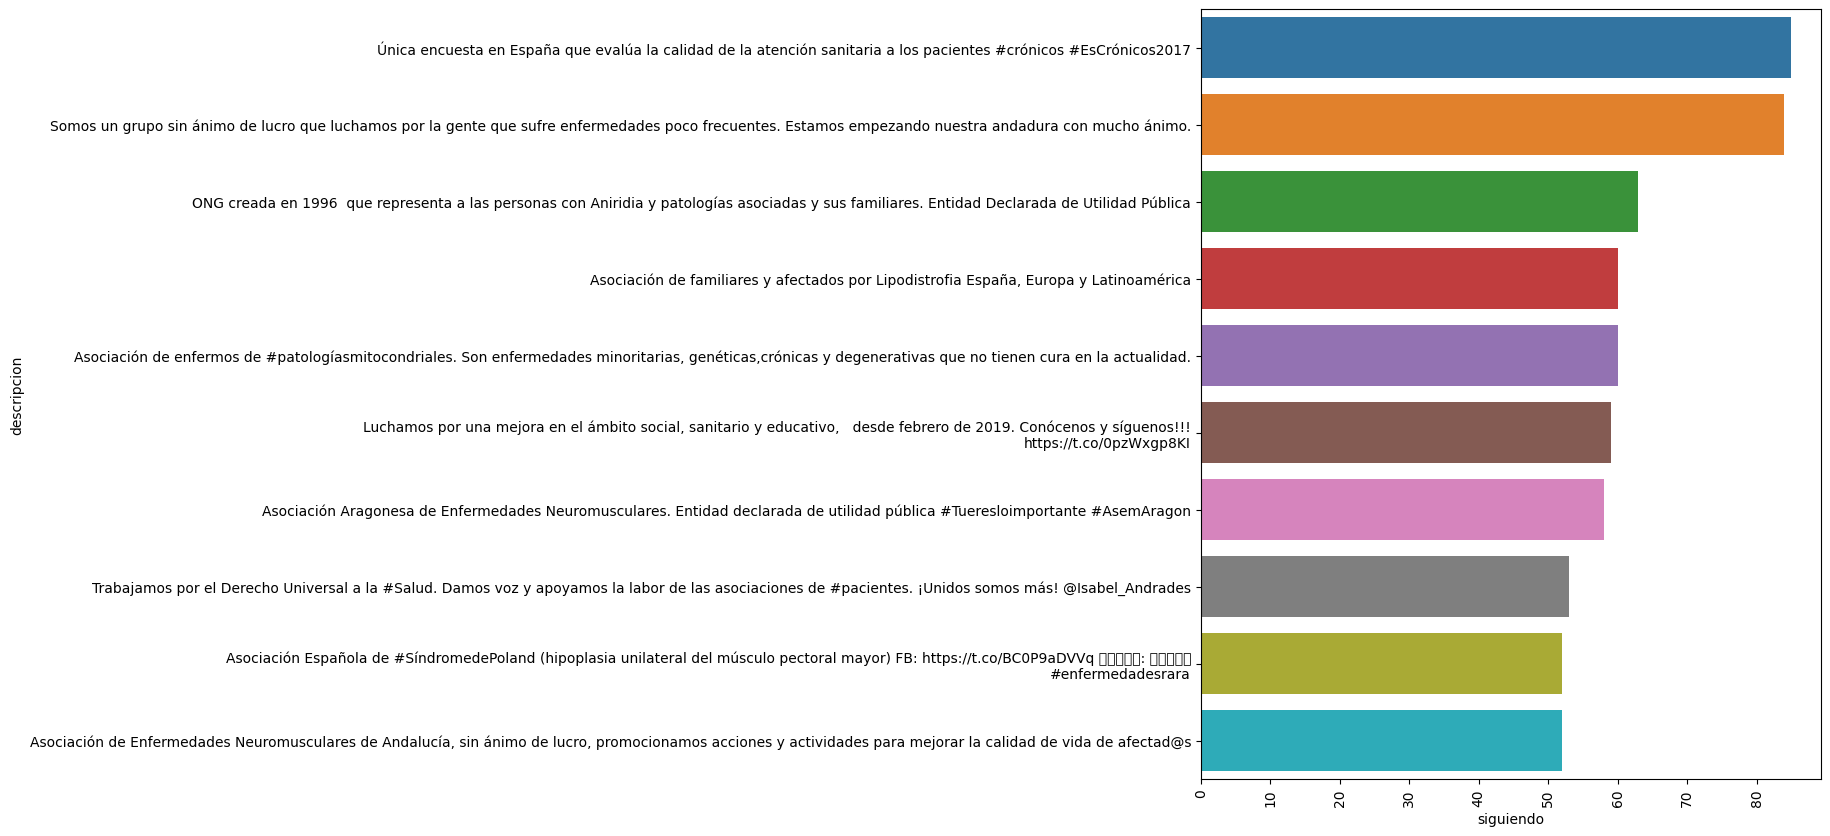

In [ ]:
figure, ax = plt.subplots(figsize=(8, 10))

sns.barplot(y='descripcion', x='siguiendo', data=df2)
plt.xticks(rotation = 90)
plt.show();

El usuario que más cuentas sigue con un total de 85, parece ser una cuenta personal (en teoría no es ningún tipo de grupo o asociación). Le siguen una fundación sin nombre especificado en la descripción y que solamente sigue una cuenta menos que el primero y en tercer lugar una ONG.

# Conectividad de red

In [ ]:
#alternativa para red dirigida, sin tener en cuenta las direcciones de las relaciones.
nx.is_weakly_connected(G)

True

En este caso, esta función toma la red como si fuese no dirigida y bajo esta suposición, indica que sin seguir la dirección de las flechas si se puede llegar de cualquier nodo a otro dentro de esta red.

In [ ]:
#alternativa para red dirigida, teniendo en cuenta las direcciones de las relaciones.
nx.is_strongly_connected(G)

False

Por otro lado, se observa que si se toman en consideración las direcciones de las relaciones en esta red, no se pueden llegar de cualquier nodo a cualquier otro.

In [ ]:
print(nx.shortest_path_length(G))

<generator object all_pairs_shortest_path_length at 0x7f1b4c1c7d10>


In [ ]:
#calcular los caminos mas cortos
caminos_cortos = dict(nx.all_pairs_shortest_path_length(G))
#pasarlos a una lista
distancia_caminos = [distancia for source in caminos_cortos for target, distancia in caminos_cortos[source].items()]

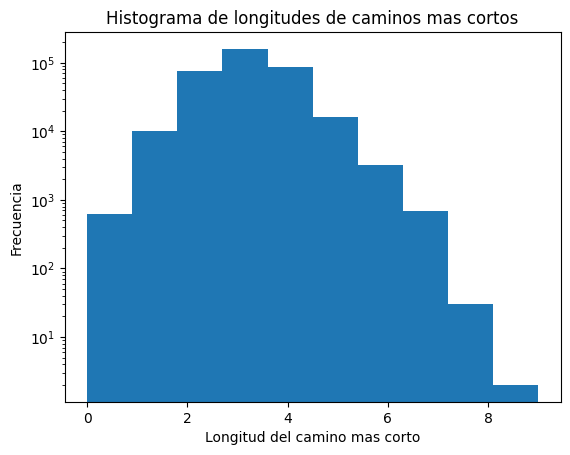

In [ ]:
plt.hist(distancia_caminos, bins=10, range = (0, max(distancia_caminos) ) )
plt.title('Histograma de longitudes de caminos mas cortos')
plt.xlabel('Longitud del camino mas corto')
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.show();

El histograma muestra una distribución ligeramente sesgada hacia la izquierda, lo que quiere decir que la mayoría de nodos se encuentran cerca entre ellos, como se observa que la longitud más frecuente se encuentra entre 2 y 4 nodos.

Esto fuese evidencia de que la red es compacta si se tratara de una red no dirigida, que no es el caso, y a pesar de que la media de la distancia entre nodos es pequeña, no se puede concluir que la red compuesta por estos datos sea compacta, ya que existen varios escenarios donde una cuenta no sigue a la otra y viceversa.


Coeficiente de Agrupamiento

In [ ]:
nx.average_clustering(G)

0.22463181186055403

El valor de coeficiente de agrupamiento bajo es evidencia de que la red no es compacta, es decir, esta dispersa.

Text(0, 0.5, 'Conteo')

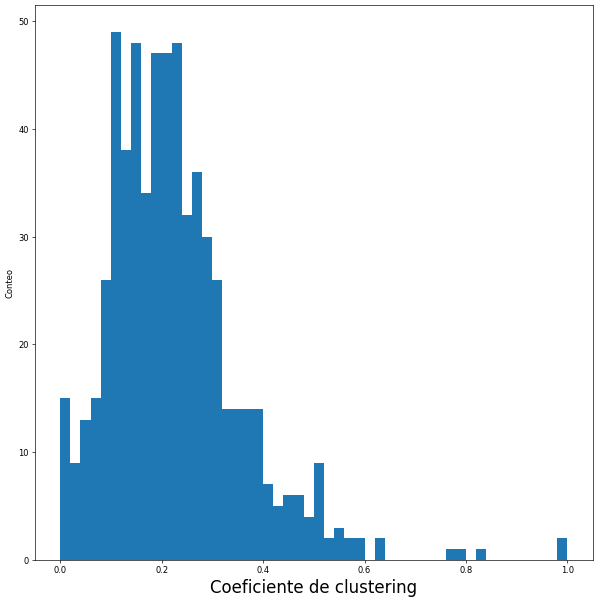

In [ ]:
plt.figure(1, figsize=(12,12), dpi=60)
plt.hist(nx.clustering(G).values(), bins=50)
plt.xlabel('Coeficiente de clustering', fontdict={'size':20})
plt.ylabel('Conteo')

Se observan muchos valores de 0, lo que representa que muchas cuentas de usuarios no siguen o son seguidos por sus "cuentas vecinas". A su vez existe una gran cantidad de valores entre 0 y 0.4 que representan un agrupamiento muy bajo, y por último, cabe destacar la existencia de valores 1, que probablemente inflen la media y sean cuentas con muchos seguidores y/o seguidos.

In [ ]:
nx.algorithms.cluster.transitivity(G)

0.20696420571287327

Según la documentación, con esta función se calcula el coeficiente de transitividad de un grafo dirigido, por lo que toma en cuenta las direcciones de las relaciones (seguidores y seguidos). Analizando el resultado de este, se puede concluir que existe un gran número de triadas abiertas o en otras palabras, muchas cuentas no se siguen y/o no son seguidas entre sus vecinos.

KeyboardInterrupt: ignored

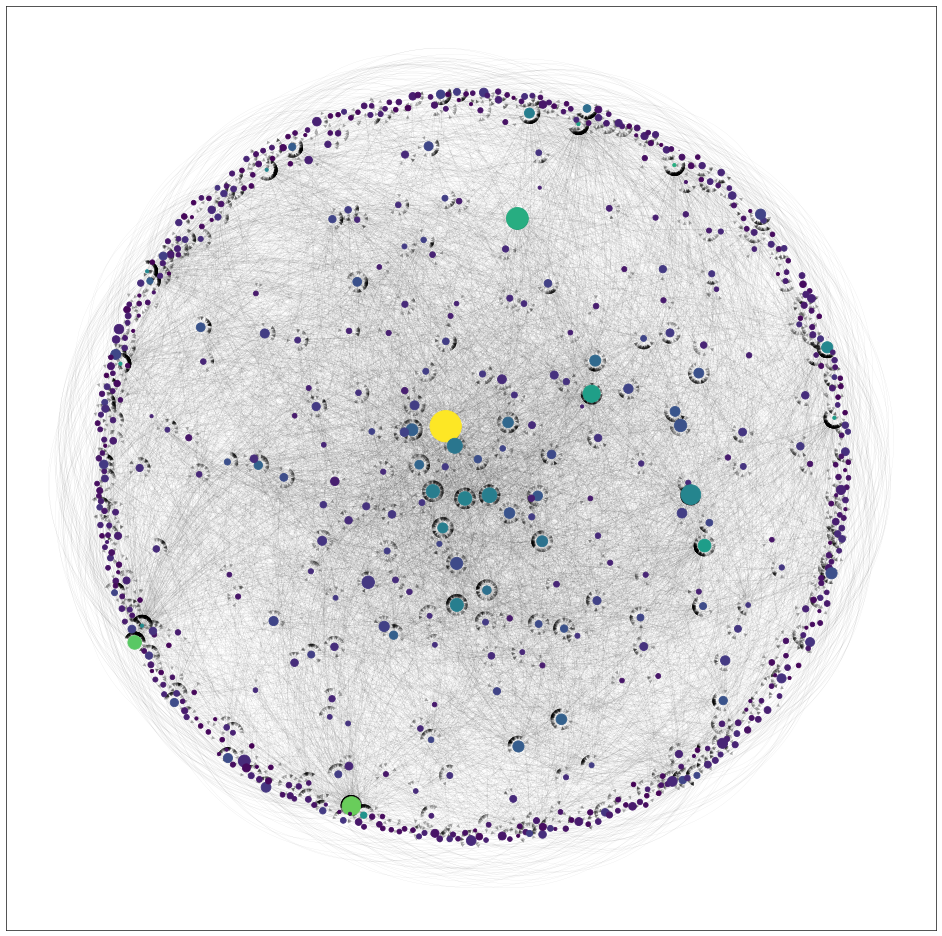

In [ ]:
plt.figure(1, figsize=(20, 20), dpi=60)

pos = nx.spring_layout (G, k=3.5, iterations=150, weight="weight", dim=2)
betCent = nx.betweenness_centrality (G, normalized=True, endpoints=True)
node_color = [20000.0 * G. degree(v) for v in G]
node_size = [v * 10000 for v in betCent.values ()]

nx.draw_networkx_nodes (G, pos, node_size=node_size, node_color=node_color, alpha=1)
nx.draw_networkx_edges (G, pos, width=0.1, connectionstyle="arc3, rad=0.5", alpha=0.3)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
#nx.draw networkx_labels (G, pos, font_size=10, bbox=label_options)

plt.axis('off');

Utilizando las líneas de código de la clase, se representa como grafico el agrupamiento entre los nodos, existen nodos que muestran agrupamiento pero no tan significante, a excepción de un solo nodo que es el mejor conectado.

# Relevancia de nodos

In [ ]:
from networkx.algorithms.bipartite.centrality import betweenness_centrality
#centralidad de grado
centralidad_seguidos = nx.out_degree_centrality(G)

centralidad_seguidores = nx.in_degree_centrality(G)

#Centralidad de cercania
closeness_centrality = nx.closeness_centrality(G)

#Centralidad de intermediacion
betweenness_centrality = nx.betweenness_centrality(G, normalized=True, endpoints=False, k=10)

#Centralidad PageRank
pagerank_centrality = nx.pagerank(G, alpha=0.8)

In [ ]:
centralidad_seguidos_top = sorted(centralidad_seguidos.items(), key=lambda x: x[1], reverse=True)[:20]

centralidad_seguidores_top = sorted(centralidad_seguidores.items(), key=lambda x: x[1], reverse=True)[:20]

closeness_top = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

between_top = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

pagerank_top = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)[:20]

In [ ]:
dict_1 = {i[0]: i[1] for i in centralidad_seguidos_top}
dict_2 = {i[0]: i[1] for i in centralidad_seguidores_top}
dict_3 = {i[0]: i[1] for i in closeness_top}
dict_4 = {i[0]: i[1] for i in between_top}
dict_5 = {i[0]: i[1] for i in pagerank_top}
df = pd.DataFrame({'seguidos': dict_1, 'seguidores':dict_2, 'closeness':dict_3,'between':dict_4, 'pagerank':dict_5})

Text(0, 0.5, 'Count')

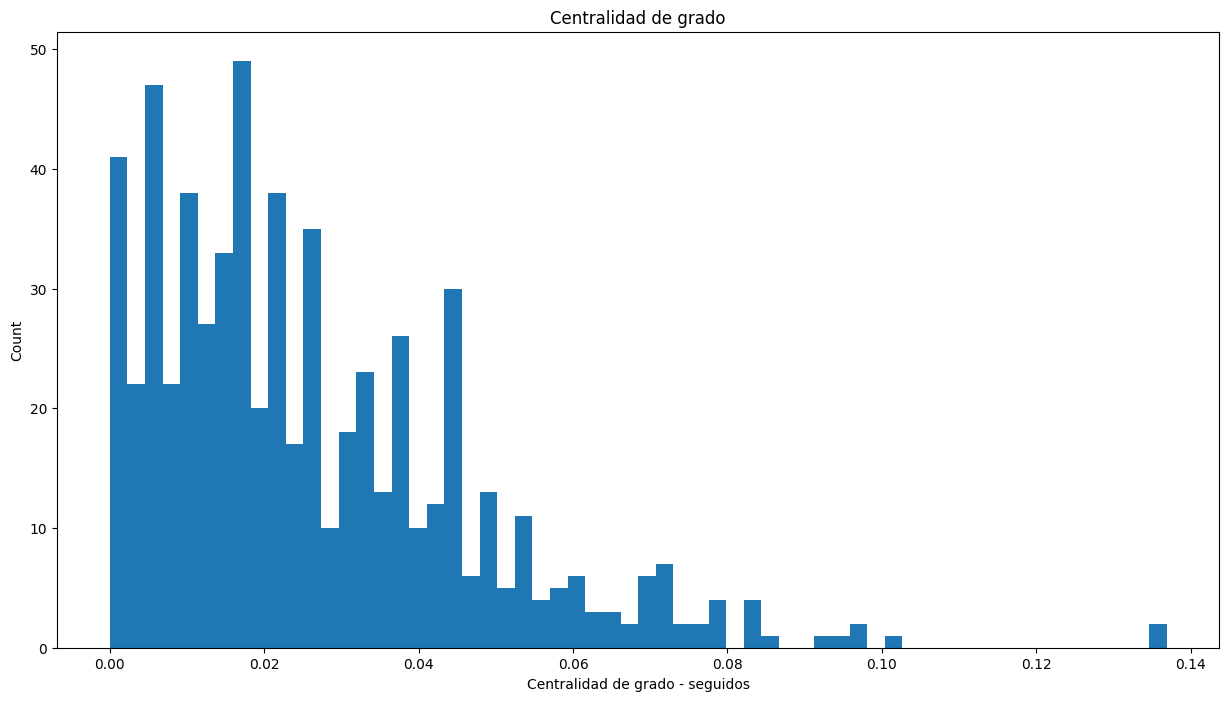

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(centralidad_seguidos.values(), bins=60)
plt.title('Centralidad de grado', loc='center')
plt.xlabel('Centralidad de grado - seguidos')
plt.ylabel("Count")

La mayoría de los nodos tienen pocas conexiones o en este contexto seguidores, lo que se refleja con la gran incidencia de valores iguales y próximos a 0. Esto se viene concluyendo desde antes, viendo por ejemplo como la cantidad máxima de seguidores de una cuenta era mucho mayor a la cantidad máxima de seguidos por otra

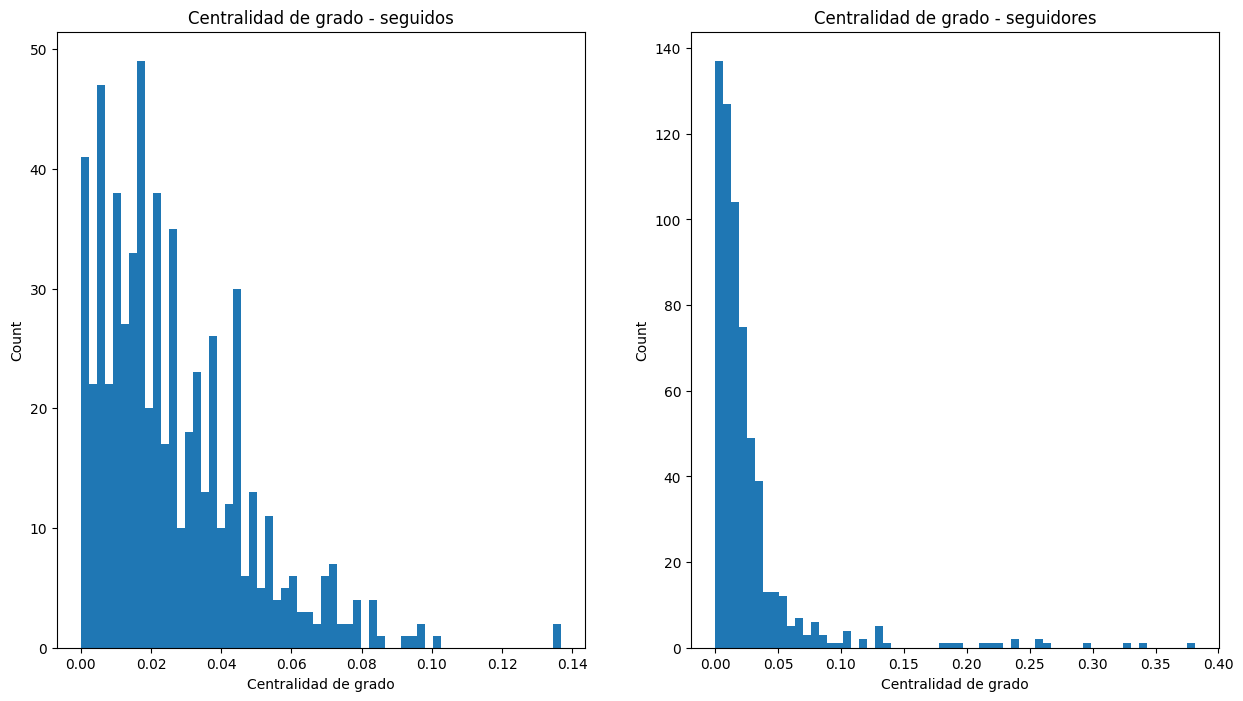

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

# Subplot 1 - Histograma de centralidad de grado - seguidos
axs[0].hist(centralidad_seguidos.values(), bins=60)
axs[0].set_title('Centralidad de grado - seguidos', loc='center')
axs[0].set_xlabel('Centralidad de grado')
axs[0].set_ylabel('Count')

# Subplot 2 - Histograma de centralidad de grado - seguidores
axs[1].hist(centralidad_seguidores.values(), bins=60)
axs[1].set_title('Centralidad de grado - seguidores', loc='center')
axs[1].set_xlabel('Centralidad de grado')
axs[1].set_ylabel('Count')

# Mostrar gráficos
plt.show()

Predomina con gran diferencia los valores a 0, lo que quiere decir que la gran mayoría de cuentas no cuentan con la influencia necesaria para transmitir sus publicaciones y que esta llegue a todos los usuarios de esta red.

Text(0, 0.5, 'Count')

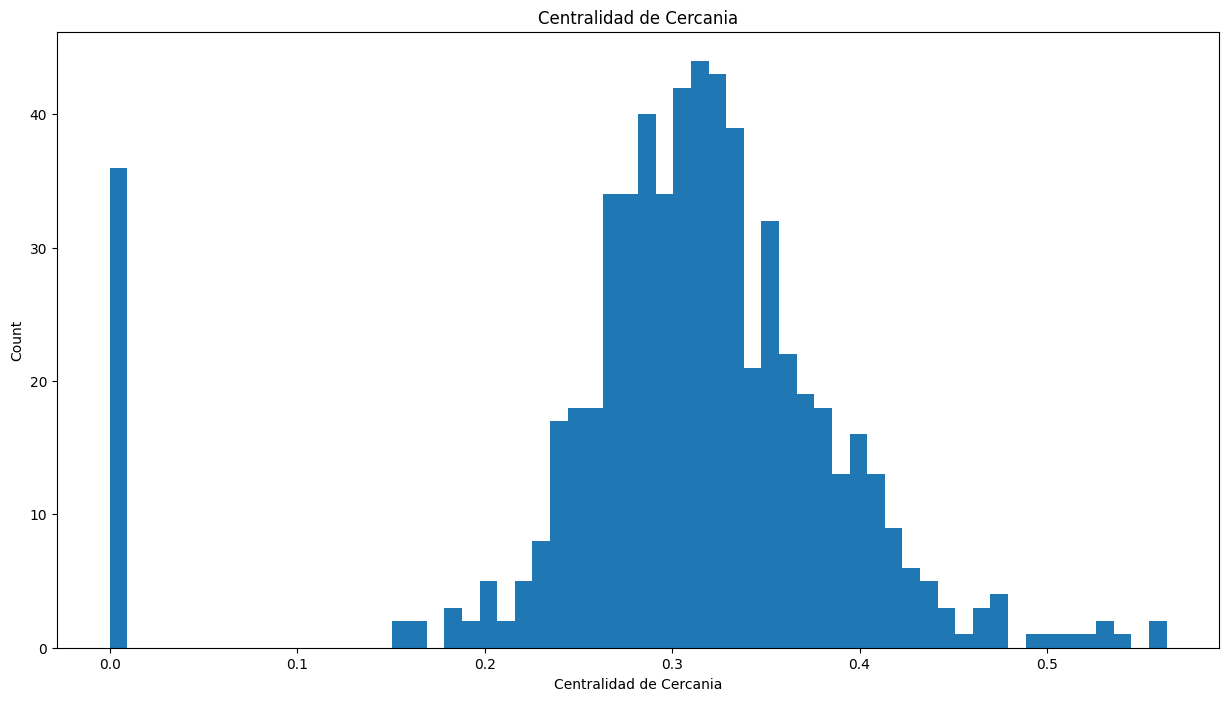

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title('Centralidad de Cercania', loc='center')
plt.xlabel('Centralidad de Cercania')
plt.ylabel("Count")

Existe una gran cantidad de valores iguales a 0, lo que indica que hay una baja capacidad de conexión entre las cuentas de esta red. Aislando el caso de los valores igual a 0, se obtienen la mayoría de valores en los rangos de 0.2 y 0.4 aproximadamente, que sigue siendo un valor pequeño respaldando la teoría de que las cuentas no se siguen mutuamente entre sí en su totalidad. Por último, se pueden destacar valores por encima del 0.5 que representan las cuentas dentro de la red que cuentan con un mayor número de seguidores.

In [ ]:
df.sort_values('closeness', ascending=False).head(1)

seguidos  seguidores  closeness   between  pagerank
256303752  0.085346    0.381643    0.56378  0.087583  0.012257

In [ ]:
print(f'El usuario mas relevante de acuerdo con el coeficiente de cercania con un valor de {max(df.closeness.dropna())}, contiene el numero de identificacion de tweet "256303752"\n y su descripcion del perfil es:\n {G.nodes[256303752]["description"]} ')

El usuario mas relevante de acuerdo con el coeficiente de cercania con un valor de 0.5637795051393754, contiene el numero de identificacion de tweet "256303752"
 y su descripcion del perfil es:
 Trabajamos por el Derecho Universal a la #Salud. Damos voz y apoyamos la labor de las asociaciones de #pacientes. ¡Unidos somos más! @Isabel_Andrades 


En este caso se observa un resultado logico, ya que recordadndo anteriormente esta descripcion y numero de identificador, representa a la cuenta con mayor numero de seguidores dentro de la red.

Text(0, 0.5, 'Count')

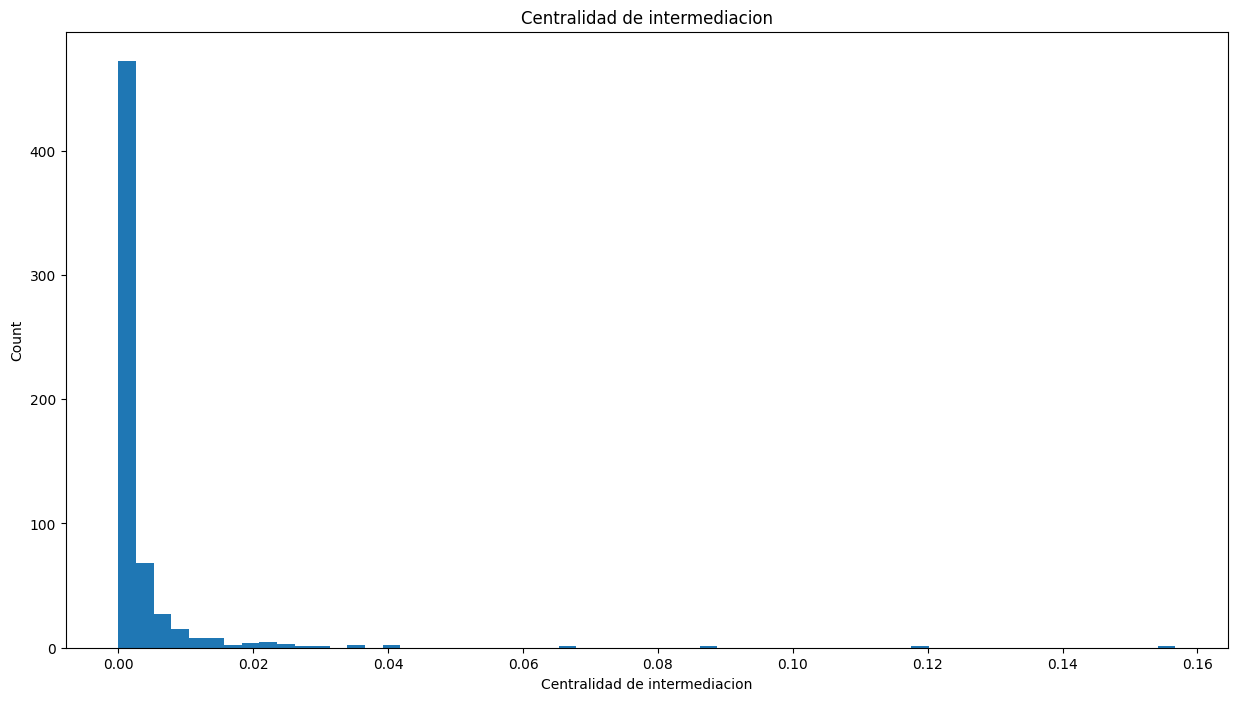

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=60)
plt.title('Centralidad de intermediacion', loc='center')
plt.xlabel('Centralidad de intermediacion')
plt.ylabel("Count")

El grafico muestra una baja interconexión entre las cuentas de usuarios, la mayoría de las cuentas no se siguen recíprocamente, lo que dificulta crear nuevas relaciones entre usuarios. Predominan los valores iguales a 0 y el valor más alto es de 0.12 lo cual sigue siendo bajo. Se podría decir que esta red está compuesta por cuentas poco relacionadas entre si o que existe alguna cuenta fuera de este conjunto de datos que influya significativamente más como conector entre estas.

In [ ]:
df.sort_values('between', ascending=False).head(1)

seguidos  seguidores  closeness   between  pagerank
198867180       NaN    0.241546   0.507451  0.156727  0.013324

In [ ]:
print(f'El usuario mas relevante de acuerdo con el coeficiente de intermediacion con un valor de {max(df.between.dropna())}, contiene el numero de identificacion de tweet "256303752"\n y su descripcion del perfil es:\n {G.nodes[256303752]["description"]} ')

El usuario mas relevante de acuerdo con el coeficiente de intermediacion con un valor de 0.1567273901246705, contiene el numero de identificacion de tweet "256303752"
 y su descripcion del perfil es:
 Trabajamos por el Derecho Universal a la #Salud. Damos voz y apoyamos la labor de las asociaciones de #pacientes. ¡Unidos somos más! @Isabel_Andrades 


En este caso también es la supuesta usuaria "Isabel Andrades" quien obtiene el valor más alto y relevante de coeficiente de intermediación, hecho que o sorprende por ser la usuaria con más seguidores que la convierte a su vez en la más influyente de la red creada.

Text(0, 0.5, 'Count')

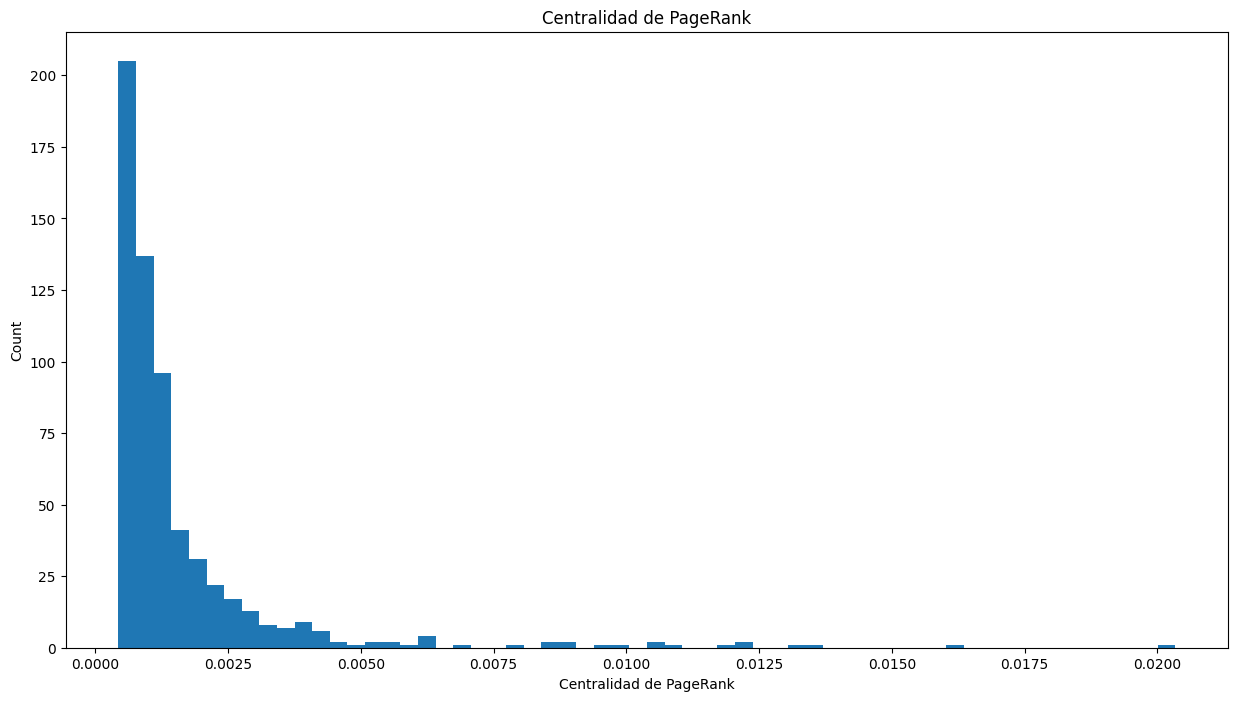

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(pagerank_centrality.values(), bins=60)
plt.title('Centralidad de PageRank', loc='center')
plt.xlabel('Centralidad de PageRank')
plt.ylabel("Count")

Nuevamente para esta medida predomina el valor igual a 0, y como se ha estado concluyendo a lo largo del ejercicio, dentro de la red no existe una influencia predominante por uno de los usuarios o nodos, dada su baja interconexión.
Quien se consideraría de mayor influencia en esta red es la cuenta con mayor número de seguidores y que a su vez se encuentra en el top de cuentas que más siguen a otras.


In [ ]:
top = pd.DataFrame({'closeness':dict_3, 'pagerank':dict_5})
top['sumatoria'] = top.closeness + top.pagerank
top.sort_values('sumatoria', ascending=False)

closeness  pagerank  sumatoria
2974326351            0.557211  0.020339   0.577550
256303752             0.563780  0.012257   0.576037
271099251             0.540421  0.010659   0.551081
367210075             0.531182  0.013551   0.544733
1280142038667755520   0.527652  0.016246   0.543898
308131267             0.519325  0.012198   0.531523
198867180             0.507451  0.013324   0.520775
847726106937409536    0.504170  0.009458   0.513629
1327897933036072963   0.494718  0.010981   0.505699
19394390              0.479071  0.008935   0.488006
139765056             0.476288  0.008879   0.485167
920282323446312960    0.473562  0.010547   0.484109
3964381883            0.473929  0.010006   0.483934
1127499633595420672   0.465095  0.011749   0.476844
1266055351633432578   0.464719  0.007873   0.472591
154210893             0.458481  0.008552   0.467033
3380098641            0.449083  0.008505   0.457588
1137790251852861441   0.447681  0.006350   0.454032
3043358051            0.462845       NaN        NaN
877527635827593216    0.449083       NaN        NaN
3013230070                 NaN  0.006779        NaN
709859902395707392         NaN  0.006328        NaN

*EL* valor más alto en cuento a coeficiente de cercanía no es el más alto para el caso del coeficiente de Pagerank. En este caso la segunda cuenta con más seguidores es la que posee una capacidad más alta para difundir su contenido y, sin embargo, no es la que en cuanto a red, tenga más cercanos otros usuarios lo que conlleva una difusión del contenido a la red en su totalidad menos rápida o eficiente.

In [ ]:
grupos = {}
for cuenta in top.index:
  grupos[cuenta] = {'id_tweet': cuenta, 'grupo': G.nodes[cuenta]['grupo']}


df_grupos = pd.DataFrame(grupos)
final = pd.merge(top, df_grupos.T, left_index=True, right_index=True)
final


closeness  pagerank  sumatoria             id_tweet  \
256303752             0.563780  0.012257   0.576037            256303752   
2974326351            0.557211  0.020339   0.577550           2974326351   
271099251             0.540421  0.010659   0.551081            271099251   
367210075             0.531182  0.013551   0.544733            367210075   
1280142038667755520   0.527652  0.016246   0.543898  1280142038667755520   
308131267             0.519325  0.012198   0.531523            308131267   
198867180             0.507451  0.013324   0.520775            198867180   
847726106937409536    0.504170  0.009458   0.513629   847726106937409536   
1327897933036072963   0.494718  0.010981   0.505699  1327897933036072963   
19394390              0.479071  0.008935   0.488006             19394390   
139765056             0.476288  0.008879   0.485167            139765056   
3964381883            0.473929  0.010006   0.483934           3964381883   
920282323446312960    0.473562  0.010547   0.484109   920282323446312960   
1127499633595420672   0.465095  0.011749   0.476844  1127499633595420672   
1266055351633432578   0.464719  0.007873   0.472591  1266055351633432578   
3043358051            0.462845       NaN        NaN           3043358051   
154210893             0.458481  0.008552   0.467033            154210893   
3380098641            0.449083  0.008505   0.457588           3380098641   
877527635827593216    0.449083       NaN        NaN   877527635827593216   
1137790251852861441   0.447681  0.006350   0.454032  1137790251852861441   
3013230070                 NaN  0.006779        NaN           3013230070   
709859902395707392         NaN  0.006328        NaN   709859902395707392   

                          grupo  
256303752            asociacion  
2974326351           asociacion  
271099251                   ong  
367210075              no_class  
1280142038667755520    no_class  
308131267              no_class  
198867180              no_class  
847726106937409536     no_class  
1327897933036072963  asociacion  
19394390             asociacion  
139765056                   ong  
3964381883                  ong  
920282323446312960   asociacion  
1127499633595420672    no_class  
1266055351633432578    no_class  
3043358051           asociacion  
154210893              no_class  
3380098641             no_class  
877527635827593216   asociacion  
1137790251852861441         ong  
3013230070           asociacion  
709859902395707392   asociacion

In [ ]:
final.grupo.value_counts()

asociacion    9
no_class      9
ong           4
Name: grupo, dtype: int64

Se intentó buscar algún tipo de patrón o característica clave que brindara mayor información sobre los tipos de cuenta que mejores resultados sobre esta métrica obtenían, pero los grupos tienen valores similares, y lo mas que se puede deducir es que las cuentas de asociaciones y cuentas normales o de un usuario (se supone que son estas ya que el atributo las especifica como sin clase) son las que tienen mejor resultado de estos coeficientes.

# Visualización de la red

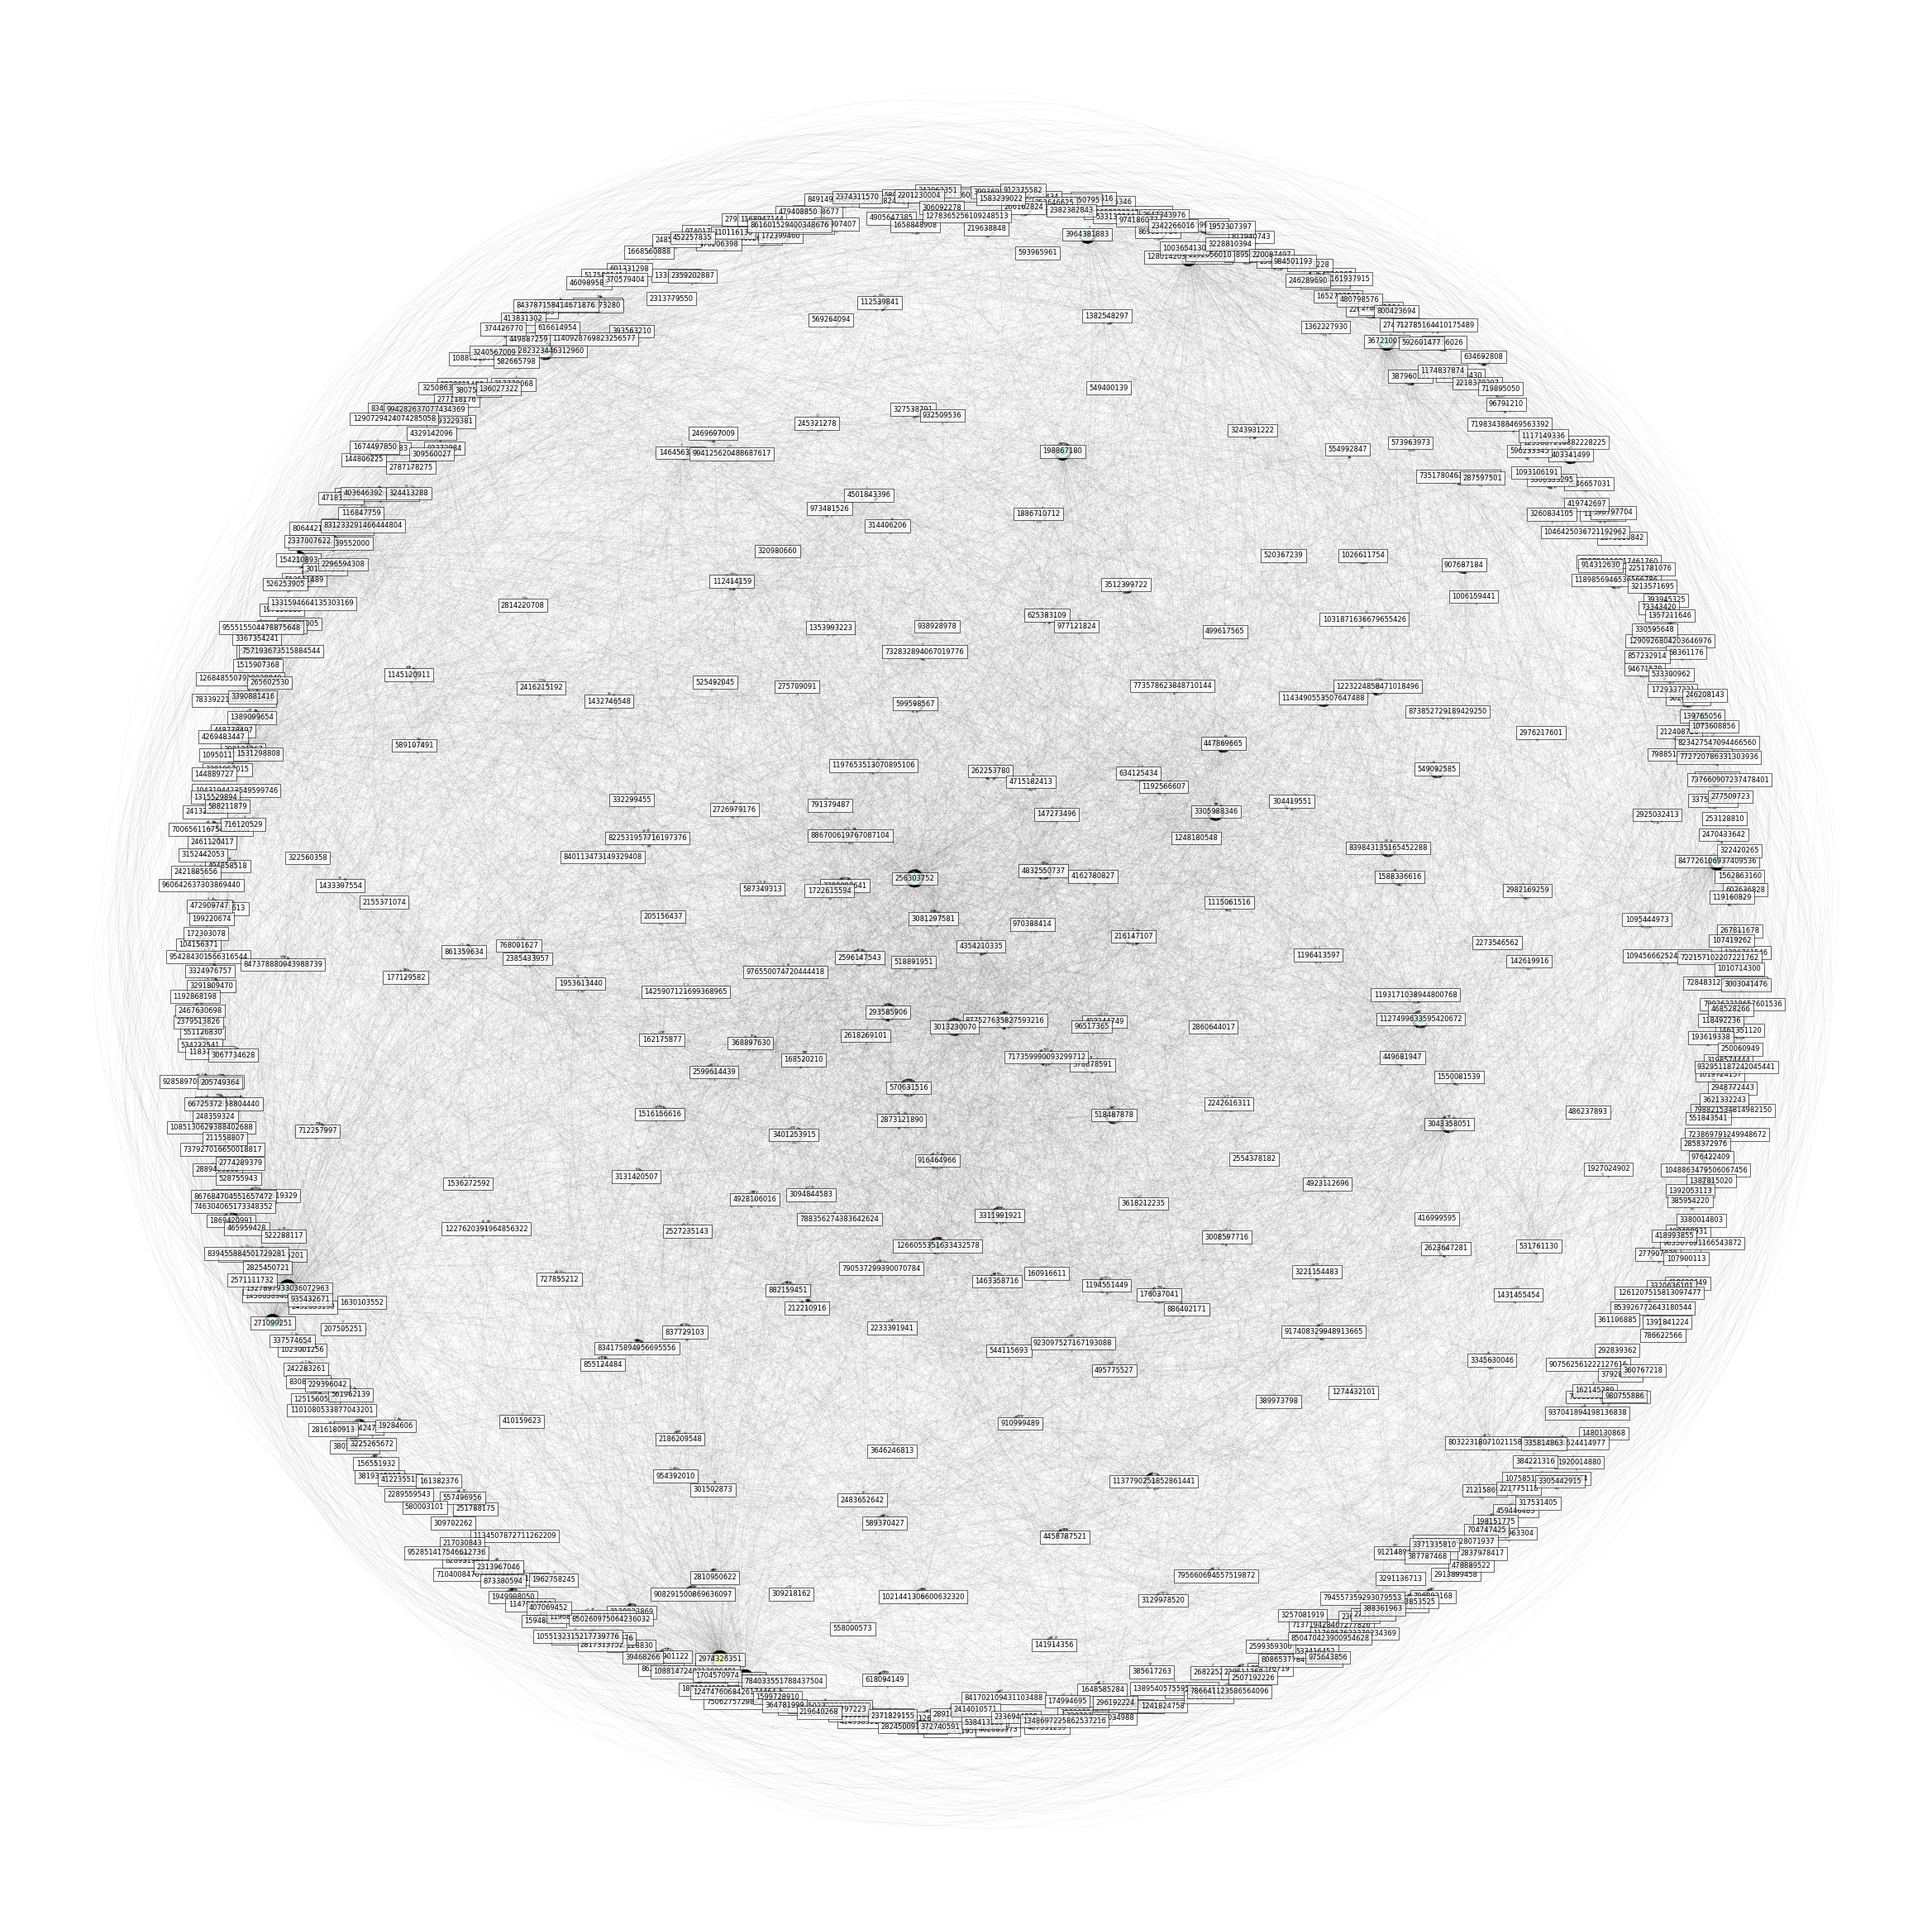

In [ ]:
#Creamos un lienzo más grande
plt.figure(1, figsize=(50, 50), dpi=60)
pagerank_centrality_G= nx.pagerank(G, alpha=0.8)
# Generamos tamaños de nodo más grandes para valores de PAgeRank más grandes
node_size = [ v * 10000 for v in pagerank_centrality_G.values()]

node_color = [20000.0* v for v in pagerank_centrality_G.values()]

nx.draw_networkx_nodes (G, pos, node_size=node_size, node_color=node_color, alpha=1)
nx.draw_networkx_edges (G, pos, width=0.1, connectionstyle="arc3, rad=0.5", alpha=0.3)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels (G, pos, font_size=10, bbox=label_options)


plt.axis('off');